In [1]:
import os
import pandas as pd
import librosa  
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader 
from tqdm.notebook import tqdm




In [2]:
df = pd.read_csv('meta/esc50.csv')

In [3]:
df.head(10)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
5,1-101296-B-19.wav,1,19,thunderstorm,False,101296,B
6,1-101336-A-30.wav,1,30,door_wood_knock,False,101336,A
7,1-101404-A-34.wav,1,34,can_opening,False,101404,A
8,1-103298-A-9.wav,1,9,crow,False,103298,A
9,1-103995-A-30.wav,1,30,door_wood_knock,False,103995,A


In [4]:
train = df[df['fold']!=5] dddddd
valid = df[df['fold']==5]

In [5]:
wav, sr = librosa.load('audio/1-100032-A-0.wav', sr=None) #audio will be sampled at given / defalut rate. len(wav) = sampling rate * time(s)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds{len(wav)}') #f'blakabkakak {name1}, {name2}. balbla'

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds220500


In [6]:
#making spectrogram using librosa
# input_nfft = int(round(sr*frame_length))
# frame_length = input_nfft/sr

def get_spectrogram(path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=830, top_db=80):
    wav, sr = librosa.load(path, sr=sr)
    melspec = librosa.feature.melspectrogram(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, 
                                             fmin=fmin, fmax=fmax)
    melspec_db = librosa.power_to_db(melspec, top_db=top_db)
    return melspec_db
  
    
    

In [7]:
def spec_to_image(spec, eps=1e-6):
    std = spec.std()
    mean = spec.mean()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min) # 0 ~ 255 scaling 공식
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled


In [8]:
class ECC50(Dataset):
    def __init__(self, base, df, in_col, out_col):
        super().__init__()
        self.df = df
        self.data = []
        self.labels = []
        self.c2i = {}
        self.i2c = {}
        self.categories = sorted(df[out_col].unique())
        for i, category in enumerate(self.categories):
            self.i2c[i] = category
            self.c2i[category] = i
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind] 
            file_path = os.path.join(base, row[in_col]) 
            self.data.append(spec_to_image(get_spectrogram(file_path))[np.newaxis,...])
            self.labels.append(self.c2i[row['category']])
    def __len__(self): 
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
                
            

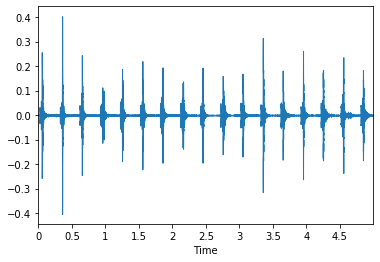

In [9]:
filename = valid[valid['category'] == 'clock_tick'].iloc[0]['filename']
wav, sr = librosa.load('audio/'+filename, sr=None)
librosa.display.waveplot(wav, sr)


/home/dayclear94/anaconda3/lib/python3.7/site-packages/librosa/filters.py:235: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


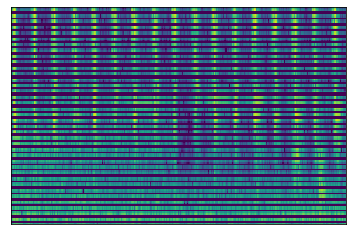

In [10]:
librosa.display.specshow(spec_to_image(get_spectrogram('audio/'+filename)), cmap='viridis')


In [11]:
train_data = ECC50('audio', train, 'filename', 'category')

In [12]:
valid_data = ECC50('audio', valid, 'filename', 'category')

In [13]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True) 


In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [67]:
class PlainClassifier(nn.Module):
    def __init__(self, input_shape, batch_size=16, num_categories=50):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.scores = nn.Linear(64*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2), num_categories)
   
    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        x = self.bn3(self.conv3(x))
        x = F.relu(x)       
        x = self.bn4(self.conv4(x))
        x = F.relu(x)
        return self.scores(x)


In [68]:
model = PlainClassifier((1,128,431)).to(device)

In [69]:
train_losses = []
valid_losses = []
epochs = 50
learning_rate = 2e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.999), eps=1e-8, weight_decay=5e-4, amsgrad=True)


In [72]:
def train(model, train_loader, valid_loader, optimizer, train_losses, epoches, valid_losses ):
    for epoch in tqdm(range(1,epochs+1)):
        model.train()
        batch_losses = []
        for i, data in enumerate(train_loader): 
            x, y = data #x = 16 images, y = label
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32) # 왜 봐꿔줌
            y = y.to(device, dtype=torch.long) #왜 바꿔줌
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)
        print(f'Epoch : {epoch} | Train loss : {np.mean(train_losses[-1])}')
        model.eval()
        batch_losses = []
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = F.CrossEntropy(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())
            batch_losses.append(loss.item())
        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y) 
        trace_yhat = np.concatenate(trace_yhay)
        accuracy = np.mean(trace_yhat.argmax(axis=1) == trace_y)
        print(f'Epoch : {epoch} | Valid loss : {np.mean(valid_losses[-1])}')
            

In [73]:
train(model, train_loader, valid_loader, optimizer, train_losses, epochs, valid_losses)

RuntimeError: size mismatch, m1: [131072 x 431], m2: [3530752 x 50] at /opt/conda/conda-bld/pytorch_1579022030672/work/aten/src/TH/generic/THTensorMath.cpp:136

In [ ]:
# plot plain
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()

plt.figure(1)
plt.subplot(121)
plt.plot(tl)
plt.legned(['train losses'])
plt.subplot(122)
plt.plot(vl)
plt.legend(['valid losses'])
plt.show()

In [ ]:
from torchvision.models import resnet34
resnet_34 = resnet34(pretrained=True)
resnet_34.fc = nn.Linear(512, 50)
resnet_34.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet_34.model = resnet_34.to(device) # move model to CPU or GPU

In [ ]:
learning_rate = 2e-4
epochs = 50
optimizer = optim.Adam(resnet_34.parameters(), lr=learning_rate, betas=(0.9,0.999), eps=1e-8, weight_decay=5e-4, amsgrad=True)
resnet_train_losses = []
resnet_valid_losses = []
train(resnet_34, train_loader, valid_loader, optimizer, resnet_train_losses, epochs, resnet_valid_losses)

In [ ]:
# plot plain
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()

plt.figure(1)
plt.subplot(121)
plt.plot(tl)
plt.legned(['train losses'])
plt.subplot(122)
plt.plot(vl)
plt.legend(['valid losses'])
plt.show()